# Eikonal traveltime tomography for seismic exploration scenarios

@Author: Ettore Biondi - ebiondi@caltech.edu

To use this notebook, we need pykonal installed. In your env, you can install it by:
1. `conda install cython`
2. `pip install git+https://github.com/malcolmw/pykonal@0.2.3b3`

In this notebook, we will apply the Eikonal tomography operators on a more realistic example using the Marmousi2 model. We will test two scenarios:
1. a [cross-well case](#cross)
2. a [surface-acquisition test](#surf)

In [1]:
import numpy as np
import occamypy as o
import eikonal2d as k

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet',
    'image.aspect'   : 'equal',
    'axes.grid'      : True,
    'figure.figsize' : (19, 8),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## <a id='cross'></a>Cross-well tomography

Let's plot the true model. Along with the geometry for the cross-well tomography example using a section of the Marmousi.

In [2]:
# Reading velocity model
nx = 1700
nz = 350
dx = 0.01
dz = 0.01
ox = 0.0
oz = 0.0
MarmTrue = np.reshape(np.fromfile("data/Marmousi2Vp.bin", dtype=">f"), (nx,nz)).astype(np.float32)

MarmTrue = MarmTrue[600:1200,:]

desampling=4
dx *= desampling
dz *= desampling
MarmTrue = MarmTrue[::desampling,::desampling]
nx,nz = MarmTrue.shape

# Velocity model
vvTrue = o.VectorNumpy(MarmTrue, ax_info=[o.AxInfo(nx, ox, dx, "x [km]"),
                                          o.AxInfo(nz, oz, dz, "z [km]")])

extent = [vvTrue.ax_info[0].o, vvTrue.ax_info[0].last, vvTrue.ax_info[1].last, vvTrue.ax_info[1].o]

In [3]:
# Source/Receiver positions
SouPos = np.array([[int(nx*0.5),iz] for iz in np.arange(0,nz,2)])
RecPos = np.array([[0,iz] for iz in np.arange(0,nz,2)]+[[nx-1,iz] for iz in np.arange(0,nz,2)])

/tmp/ipykernel_2991700/596779931.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


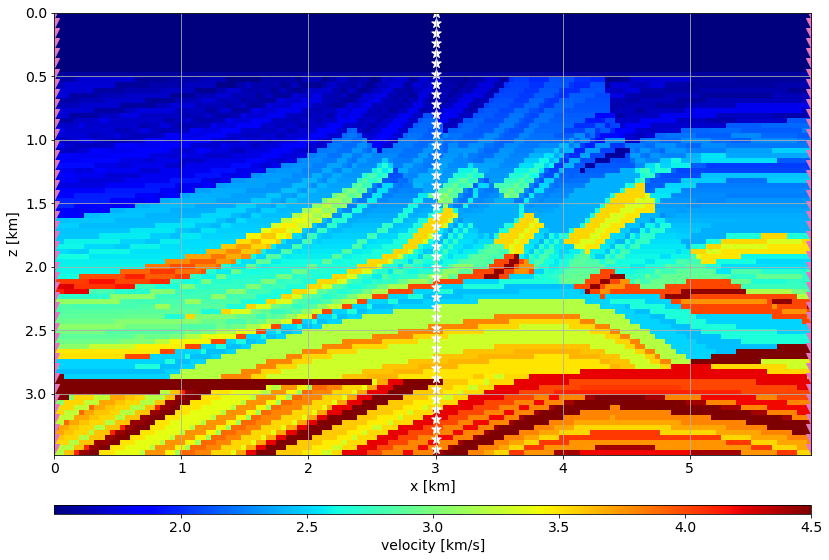

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(vvTrue.plot().T, extent=extent)

ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)
ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

Now, we can proceed to generate the observed travel times.

In [5]:
# Data vector
tt_obs = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "sou_id"),
                                 o.AxInfo(RecPos.shape[0], 0, 1, "rec_id")]).zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vvTrue, tt_obs, SouPos, RecPos)
Eik2D_Op.forward(False, vvTrue, tt_obs)

/tmp/ipykernel_2991700/594416931.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="traveltime [s]",


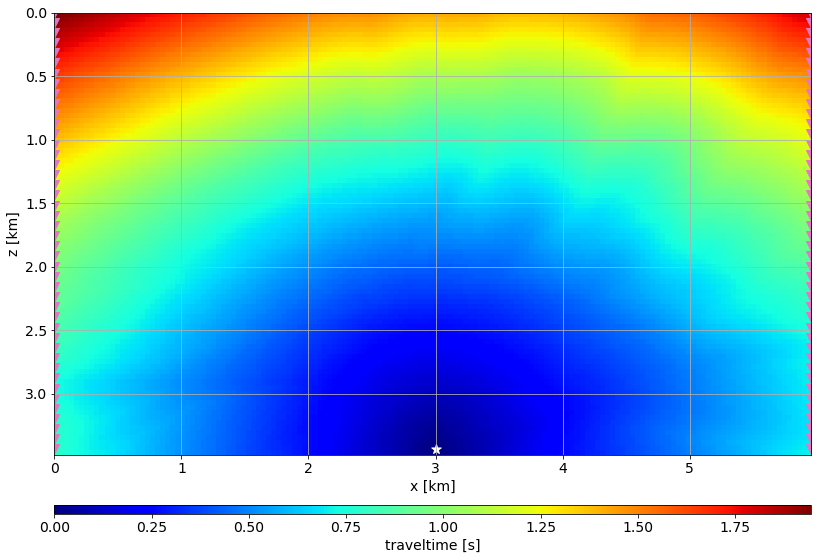

In [6]:
sou_id = -1

fig, ax = plt.subplots()

im = ax.imshow(Eik2D_Op.tt_maps[sou_id].T, extent=extent)

ax.scatter(SouPos[sou_id,0]*dx,SouPos[sou_id,1]*dz,color="white", marker="*", s=100)
ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="traveltime [s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

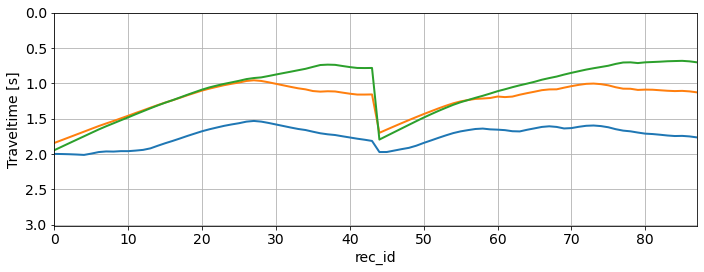

In [7]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[0,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[15,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[-1,:], lw=2)

plt.xlabel(tt_obs.ax_info[1].l)
plt.ylabel("Traveltime [s]")

ax.set_ylim(tt_obs.max()+1.0, 0)
ax.set_xlim(tt_obs.ax_info[1].o, tt_obs.ax_info[1].last)

plt.tight_layout()
plt.show()

The initial model will be constructed by smoothing the true model.

In [8]:
G = o.GaussianFilter(vvTrue, 2.5)
vvInit = G * vvTrue

/tmp/ipykernel_2991700/1045714305.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


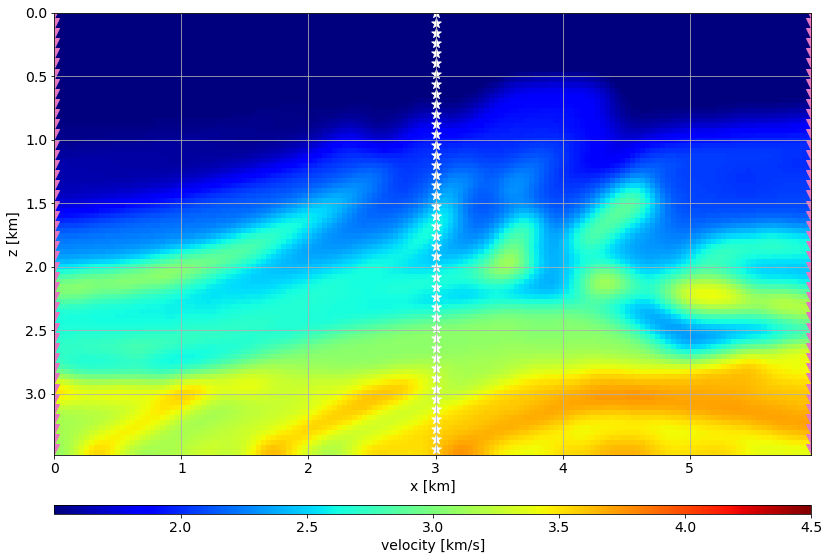

In [9]:
fig, ax = plt.subplots()

im = ax.imshow(vvInit.plot().T, extent=extent, vmin=vvTrue.min(), vmax=vvTrue.max())

ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)
ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

Let's set up the inversion problem and solve it.

In [10]:
# linear operator
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vvInit, tt_obs, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)

# nonlinear operator 
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [11]:
# instantiate solver
BFGSsolver = o.LBFGS(o.BasicStopper(niter=100, tolg_proj=1e-32), m_steps=30)

G = o.GaussianFilter(vvInit, 3.5)

Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vvInit.clone(), tt_obs, Eik2D_Inv_NlOp, 
                                     minBound=vvInit.clone().set(1.0),  # min velocity: 1.0 km/s
                                     maxBound=vvInit.clone().set(5.0))  # max velocity: 5.0 km/s

In [12]:
BFGSsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
            L-BFGS Solver 
    Max steps to invert the Hessian: 30 
    Restart folder: /tmp/restart_2022-04-22T01-52-01.992564/
##########################################################################################

iter = 000, obj = 7.82e+01, rnorm = 1.25e+01, gnorm = 6.43e+00, feval = 0001, geval = 001
iter = 001, obj = 1.57e+01, rnorm = 5.60e+00, gnorm = 1.23e+00, feval = 0002, geval = 002
iter = 002, obj = 1.11e+01, rnorm = 4.71e+00, gnorm = 8.82e-01, feval = 0003, geval = 003
iter = 003, obj = 5.35e+00, rnorm = 3.27e+00, gnorm = 6.37e-01, feval = 0004, geval = 004
iter = 004, obj = 3.43e+00, rnorm = 2.62e+00, gnorm = 5.18e-01, feval = 0005, geval = 005
iter = 005, obj = 1.89e+00, rnorm = 1.94e+00, gnorm = 3.14e-01, feval = 0006, geval = 006
iter = 006, obj = 1.37e+00, rnorm = 1.66e+00, gnorm = 2.50e-01, feval = 0007, geval = 007
iter = 007, obj = 1.02e+00, rnorm = 1.43e+00, gnorm = 2.25

iter = 088, obj = 5.37e-02, rnorm = 3.28e-01, gnorm = 6.48e-03, feval = 0089, geval = 089
iter = 089, obj = 5.31e-02, rnorm = 3.26e-01, gnorm = 6.49e-03, feval = 0090, geval = 090
iter = 090, obj = 5.26e-02, rnorm = 3.24e-01, gnorm = 6.03e-03, feval = 0091, geval = 091
iter = 091, obj = 5.22e-02, rnorm = 3.23e-01, gnorm = 5.62e-03, feval = 0092, geval = 092
iter = 092, obj = 5.19e-02, rnorm = 3.22e-01, gnorm = 5.59e-03, feval = 0093, geval = 093
iter = 093, obj = 5.17e-02, rnorm = 3.21e-01, gnorm = 5.49e-03, feval = 0094, geval = 094
iter = 094, obj = 5.14e-02, rnorm = 3.21e-01, gnorm = 4.98e-03, feval = 0095, geval = 095
iter = 095, obj = 5.09e-02, rnorm = 3.19e-01, gnorm = 4.16e-03, feval = 0096, geval = 096
iter = 096, obj = 5.05e-02, rnorm = 3.18e-01, gnorm = 3.51e-03, feval = 0097, geval = 097
iter = 097, obj = 5.01e-02, rnorm = 3.17e-01, gnorm = 3.34e-03, feval = 0098, geval = 098
iter = 098, obj = 4.99e-02, rnorm = 3.16e-01, gnorm = 3.40e-03, feval = 0099, geval = 099
iter = 099

/tmp/ipykernel_2991700/3560037947.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


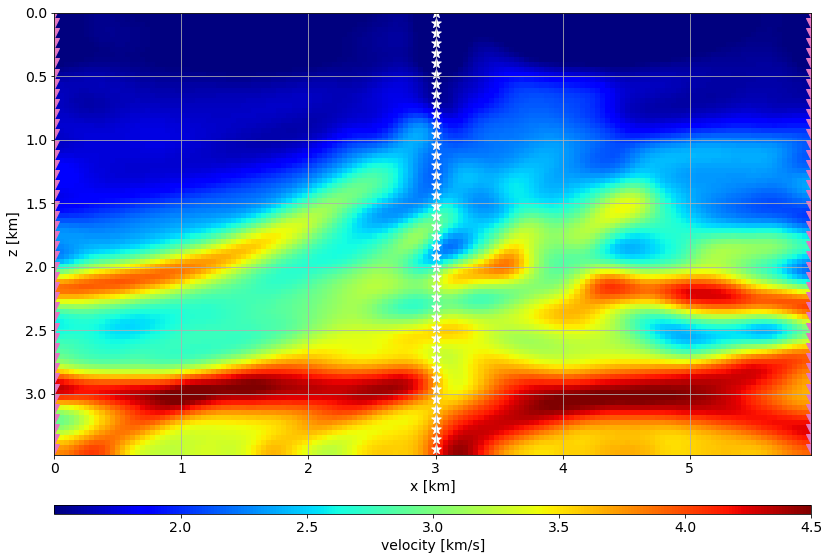

In [13]:
fig, ax = plt.subplots()

im = ax.imshow(L2_tt_prob.model.plot().T, extent=extent, vmin=vvTrue.min(), vmax=vvTrue.max())

ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)
ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

## <a id='surf'></a>First-break surface tomography

In this test we will be estimating the subsurface velocity using a surface acquisition.

In [14]:
# Reading velocity model
nx = 1700
nz = 350
dx = 0.01
dz = 0.01
ox = 0.0
oz = 0.0
MarmTrue = np.reshape(np.fromfile("data/Marmousi2Vp.bin", dtype=">f"), (nx,nz)).astype(np.float32)

desampling=4
dx *= desampling
dz *= desampling
MarmTrue = MarmTrue[::desampling,::desampling]
nx,nz = MarmTrue.shape

# Velocity model
vvTrue = o.VectorNumpy(MarmTrue, ax_info=[o.AxInfo(nx, 0, dx, "x [km]"),
                                          o.AxInfo(nz, 0, dz, "z [km]")])

extent = [vvTrue.ax_info[0].o, vvTrue.ax_info[0].last, vvTrue.ax_info[1].last, vvTrue.ax_info[1].o]

In [15]:
# Source/Receiver positions
SouPos = np.array([[ix,0] for ix in np.arange(0,nx,10)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx,2)])

/tmp/ipykernel_2991700/3681826258.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


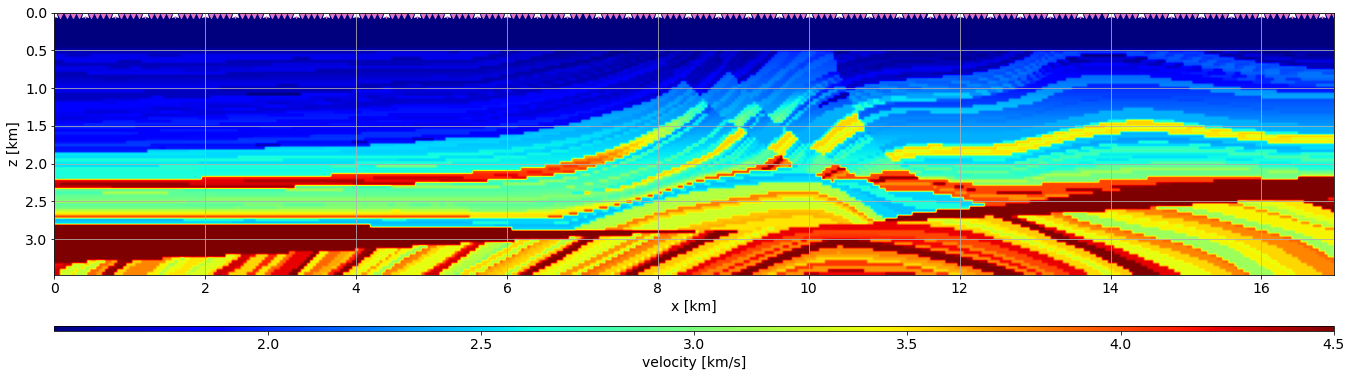

In [16]:
fig, ax = plt.subplots()

im = ax.imshow(vvTrue.plot().T, extent=extent)

ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)
ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

In [17]:
# Data vector
tt_obs = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "sou_id"),
                                 o.AxInfo(RecPos.shape[0], 0, 1, "rec_id")]).zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vvTrue, tt_obs, SouPos, RecPos)
Eik2D_Op.forward(False, vvTrue, tt_obs)

/tmp/ipykernel_2991700/2480074603.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="traveltime [s]",


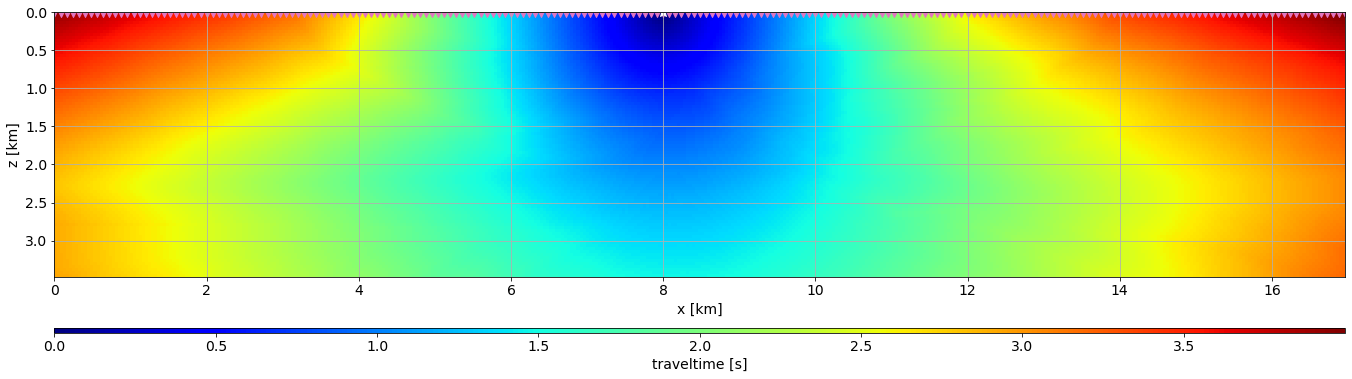

In [18]:
sou_id = 20

fig, ax = plt.subplots()

im = ax.imshow(Eik2D_Op.tt_maps[sou_id].T, extent=extent)

ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)
ax.scatter(SouPos[sou_id,0]*dx, SouPos[sou_id,1]*dz, color="white", marker="*", s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="traveltime [s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

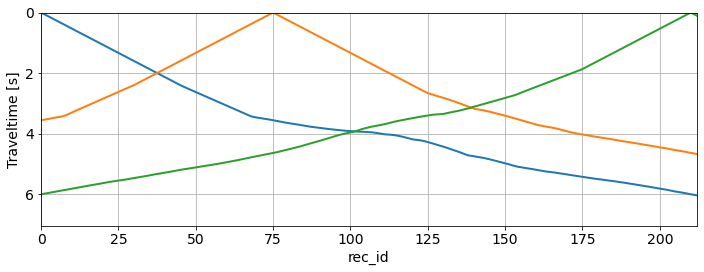

In [19]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[0,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[15,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[-1,:], lw=2)

plt.xlabel(tt_obs.ax_info[1].l)
plt.ylabel("Traveltime [s]")

ax.set_ylim(tt_obs.max()+1.0, 0)
ax.set_xlim(tt_obs.ax_info[1].o, tt_obs.ax_info[1].last)

plt.tight_layout()
plt.show()

Again, let's create a initial smooth model

In [20]:
G = o.GaussianFilter(vvTrue, 2.5)
vvInit = G * vvTrue

/tmp/ipykernel_2991700/995366468.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


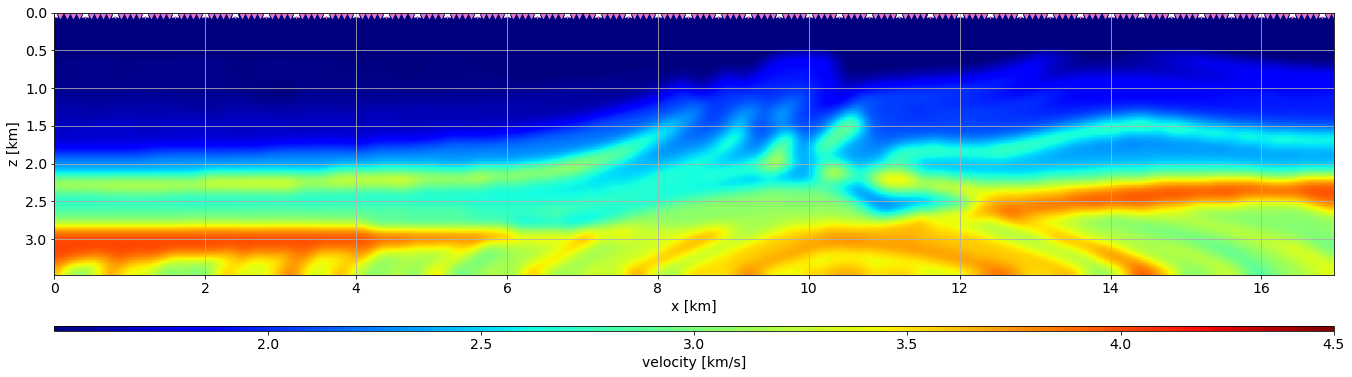

In [21]:
fig, ax = plt.subplots()

im = ax.imshow(vvInit.plot().T, extent=extent, vmin=vvTrue.min(), vmax=vvTrue.max())

ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)
ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()

In [22]:
# linear operator
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vvInit, tt_obs, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
# nonlinear operator
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [23]:
# instantiate solver
BFGSsolver = o.LBFGS(o.BasicStopper(niter=100, tolg_proj=1e-32), m_steps=30)

Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vvInit.clone(), tt_obs, Eik2D_Inv_NlOp, 
                                     minBound=vvInit.clone().set(1.0),  # min velocity: 1.0 km/s
                                     maxBound=vvInit.clone().set(5.0))  # max velocity: 5.0 km/s

In [24]:
BFGSsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
            L-BFGS Solver 
    Max steps to invert the Hessian: 30 
    Restart folder: /tmp/restart_2022-04-22T01-56-11.618210/
##########################################################################################

iter = 000, obj = 1.21e+03, rnorm = 4.93e+01, gnorm = 5.51e+01, feval = 0001, geval = 001
iter = 001, obj = 4.04e+02, rnorm = 2.84e+01, gnorm = 2.87e+01, feval = 0002, geval = 002
iter = 002, obj = 7.41e+01, rnorm = 1.22e+01, gnorm = 7.51e+00, feval = 0003, geval = 003
iter = 003, obj = 2.87e+01, rnorm = 7.58e+00, gnorm = 3.29e+00, feval = 0004, geval = 004
iter = 004, obj = 1.76e+01, rnorm = 5.94e+00, gnorm = 2.29e+00, feval = 0005, geval = 005
iter = 005, obj = 1.18e+01, rnorm = 4.86e+00, gnorm = 1.64e+00, feval = 0006, geval = 006
iter = 006, obj = 8.80e+00, rnorm = 4.20e+00, gnorm = 1.13e+00, feval = 0007, geval = 007
iter = 007, obj = 7.15e+00, rnorm = 3.78e+00, gnorm = 9.37

iter = 088, obj = 9.08e-02, rnorm = 4.26e-01, gnorm = 3.66e-02, feval = 0089, geval = 089
iter = 089, obj = 8.80e-02, rnorm = 4.20e-01, gnorm = 4.17e-02, feval = 0090, geval = 090
iter = 090, obj = 8.63e-02, rnorm = 4.15e-01, gnorm = 3.30e-02, feval = 0091, geval = 091
iter = 091, obj = 8.46e-02, rnorm = 4.11e-01, gnorm = 2.29e-02, feval = 0092, geval = 092
iter = 092, obj = 8.33e-02, rnorm = 4.08e-01, gnorm = 2.39e-02, feval = 0093, geval = 093
iter = 093, obj = 8.18e-02, rnorm = 4.05e-01, gnorm = 2.74e-02, feval = 0094, geval = 094
iter = 094, obj = 8.05e-02, rnorm = 4.01e-01, gnorm = 2.19e-02, feval = 0095, geval = 095
iter = 095, obj = 7.87e-02, rnorm = 3.97e-01, gnorm = 1.95e-02, feval = 0096, geval = 096
iter = 096, obj = 7.70e-02, rnorm = 3.92e-01, gnorm = 2.60e-02, feval = 0097, geval = 097
iter = 097, obj = 7.53e-02, rnorm = 3.88e-01, gnorm = 2.62e-02, feval = 0098, geval = 098
iter = 098, obj = 7.39e-02, rnorm = 3.84e-01, gnorm = 3.01e-02, feval = 0099, geval = 099
iter = 099

/tmp/ipykernel_2991700/3560037947.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",


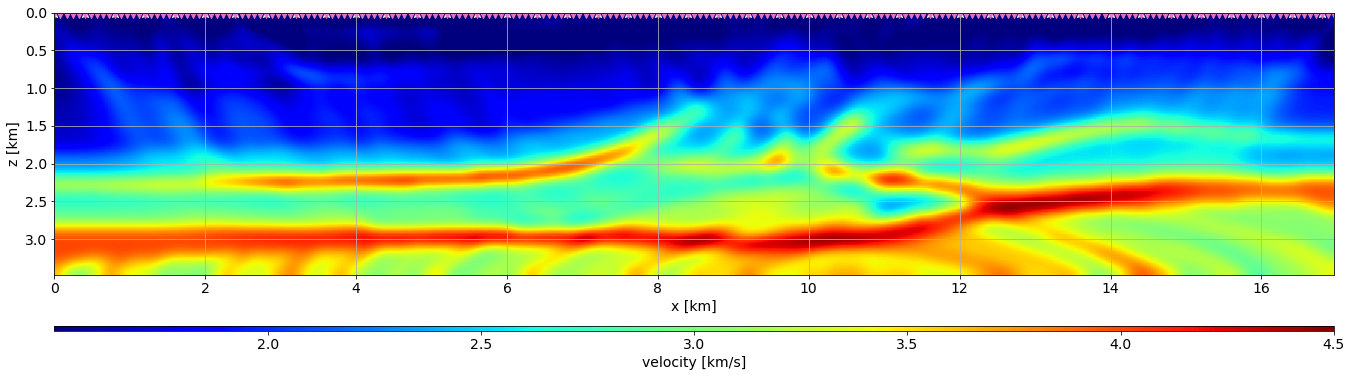

In [25]:
fig, ax = plt.subplots()

im = ax.imshow(L2_tt_prob.model.plot().T, extent=extent, vmin=vvTrue.min(), vmax=vvTrue.max())

ax.scatter(SouPos[:,0]*dx, SouPos[:,1]*dz,color="white", marker="*", s=100)
ax.scatter(RecPos[:,0]*dx, RecPos[:,1]*dz, color="tab:pink", marker="v",s=100)

plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)

cbar = plt.colorbar(im, orientation="horizontal", label="velocity [km/s]",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="2%", pad=0.7))

plt.tight_layout()
plt.show()